# audit-AI
In this notebook, we'll dive into the capabilities of the pymetrics bias-testing-package as a tool to measure and mitigate the effects discriminatory patterns in training data. We'll show how to detect bias using relatively straightforward functions, and suggest methods for correcting for bias in a few examples.

The overall goal of this research is to make machine learning algorithms more fair. In a world where decisions are increasingly automated using Artifical Intelligence, our ability to identify the adverse social impact of an algorithm is imperative for the future of machine learning. 

In this notebook, we'll be using the <a href="https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)">Statlog (German Credit Data) Data Set</a> from the UCI Machine Learning Repository, which consists of 1000 loan applications containing 20 input variables (including foreign_worker, housing, and credit_history) and 1 binary target variable credit_risk, which is either good or bad.

In the context of a machine learning model to predict good/bad credit_risk , our objectives are to:

1. Measure the degree of bias in the training data with respect to some bias metric and protected class (age, gender, visa status).
2. Train a model on the training data, make predictions on a testing set, and show that an algorithm trained on a biased training set can often lead to biased predictions.
3. Measure the effects of using a biased machine learning model.

## Import Packages/Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.metrics import (accuracy_score,
                             auc,
                             classification_report,
                             precision_score,
                             recall_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV,
                                     learning_curve,
                                     ShuffleSplit,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from auditai.viz import plot_threshold_tests

%matplotlib inline

In [2]:
# Importing preprocessed data
germancredit_df = pd.read_csv('../data/GermanCreditData.csv')
germancredit_df.shape

(1000, 51)

In [3]:
germancredit_df.head()

,duration,amount,inst_rate,personal_status,residing_since,age,num_credits,dependents,foreign_worker,status,...,inst_plans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192
0,0.256953,0.566664,0.024147,A93,1.046987,53,1.027079,2.334869,A201,0,...,1,0,0,1,0,0,1,0,1,0
1,0.754763,0.695681,0.918477,A94,-0.765977,28,1.027079,-0.428290,A201,0,...,1,0,1,0,0,0,0,1,1,0
2,-0.738668,-0.700472,0.024147,A92,-1.672459,25,-0.704926,-0.428290,A201,0,...,1,1,0,0,0,0,1,0,1,0
3,0.256953,-0.734498,0.918477,A93,1.046987,60,1.027079,-0.428290,A201,0,...,1,0,1,0,0,1,0,0,1,0
4,-0.489762,-0.662192,-0.870183,A92,1.046987,28,-0.704926,-0.428290,A201,1,...,1,1,0,0,0,0,1,0,1,0


In [4]:
# Preprocessing features 
germancredit_df['under_30'] = (germancredit_df['age'] < 30).astype(int)
germancredit_df['is_female'] = (germancredit_df['personal_status'] ==  'A92').astype(int)
germancredit_df['is_foreign_worker'] = (germancredit_df['foreign_worker'] ==  'A202').astype(int)
germancredit_df['status'].value_counts()

1    700
0    300
Name: status, dtype: int64

#### 1 here stands for good credit, and 0 stands for bad credit. 70% of the training exmaples have good credit and the other 30% have bad credit

## Measure Bias in training data

### 1. Protected class: Age

In [5]:
# Preliminary stats
breakdown_by_age = pd.value_counts(germancredit_df['under_30'].values, sort=False)
breakdown_by_age

0    629
1    371
dtype: int64

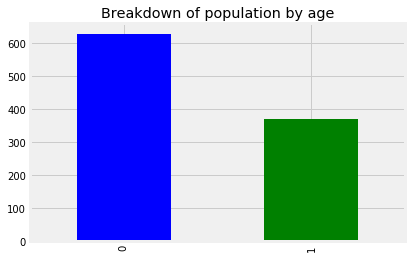

In [6]:
breakdown_by_age.plot(kind='bar', title='Breakdown of population by age',  color=['b', 'g']);

In [7]:
# Let's explore the difference of good v. bad credit for age

credit_over_30 = pd.value_counts(germancredit_df[germancredit_df['under_30'] == 0]['status'].values, sort='False', normalize=True)
credit_over_30

1    0.740859
0    0.259141
dtype: float64

In [8]:
credit_under_30 = pd.value_counts(germancredit_df[germancredit_df['under_30'] == 1]['status'].values, sort='False',normalize=True)
credit_under_30

1    0.630728
0    0.369272
dtype: float64

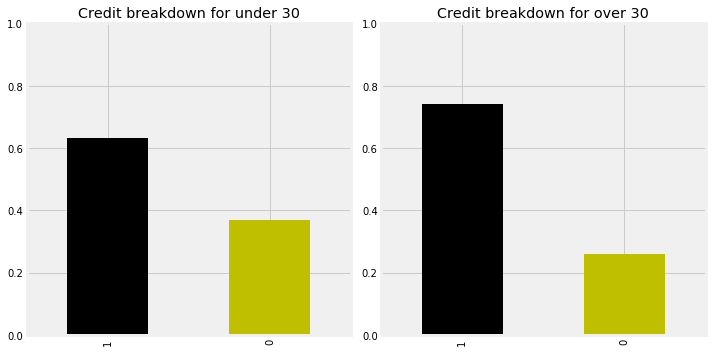

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
credit_under_30.plot(kind='bar',title='Credit breakdown for under 30', ylim =(0,1), color=['k', 'y'])
plt.subplot(1,2,2)
credit_over_30.plot(kind='bar', title='Credit breakdown for over 30', ylim = (0,1), color=['k', 'y'])
plt.tight_layout()

### 2. Protected Class: Gender

In [10]:
breakdown_by_gender = pd.value_counts(germancredit_df['is_female'].values, sort=False)
breakdown_by_gender

0    690
1    310
dtype: int64

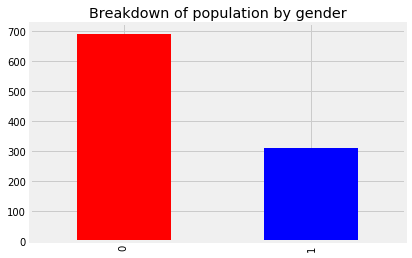

In [11]:
breakdown_by_gender.plot(kind='bar', title='Breakdown of population by gender', color=['r', 'b']);

In [12]:
# Let's explore the difference of good v. bad credit for gender

credit_mal e= pd.value_counts(germancredit_df[germancredit_df['is_female'] == 0]['status'].values, sort='False', normalize=True)
credit_male

1    0.723188
0    0.276812
dtype: float64

In [13]:
credit_female = pd.value_counts(germancredit_df[germancredit_df['is_female'] == 1]['status'].values, sort='False', normalize=True)
credit_female

1    0.648387
0    0.351613
dtype: float64

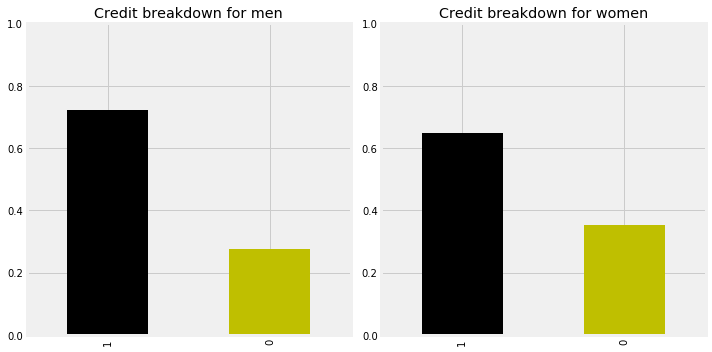

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
credit_male.plot(kind='bar',title='Credit breakdown for men', ylim=(0,1), color=['k', 'y'])
plt.subplot(1,2,2)
credit_female.plot(kind='bar', title='Credit breakdown for women', ylim=(0,1), color=['k', 'y'])
plt.tight_layout()

### 3. Protected class: Citizenship status

In [15]:
breakdown_by_citizenship = pd.value_counts(germancredit_df['is_foreign_worker'].values, sort=False)
breakdown_by_citizenship

0    963
1     37
dtype: int64

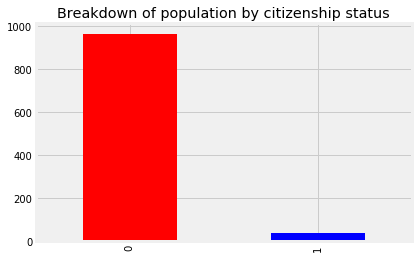

In [16]:
breakdown_by_citizenship.plot(kind='bar', title='Breakdown of population by citizenship status', color=['r', 'b']);

In [17]:
credit_citizen = pd.value_counts(germancredit_df[germancredit_df['is_foreign_worker'] == 0]['status'].values, sort='False', normalize=True)
credit_citizen

1    0.692627
0    0.307373
dtype: float64

In [18]:
credit_foreign_worker = pd.value_counts(germancredit_df[germancredit_df['is_foreign_worker'] == 1]['status'].values, sort='False', normalize=True)
credit_foreign_worker

1    0.891892
0    0.108108
dtype: float64

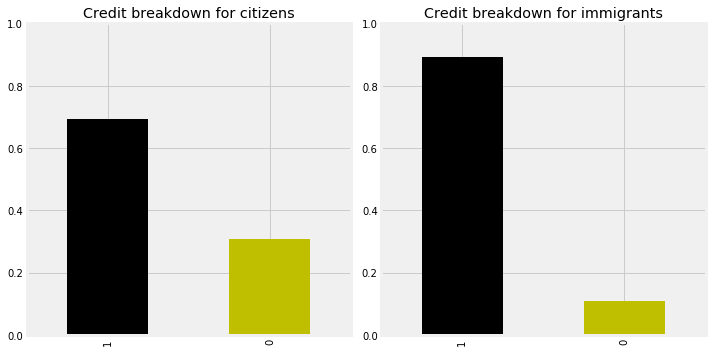

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
credit_citizen.plot(kind='bar',title='Credit breakdown for citizens', ylim=(0,1), color=['k', 'y'])
plt.subplot(1,2,2)
credit_foreign_worker.plot(kind='bar', title='Credit breakdown for immigrants', ylim=(0,1), color=['k', 'y'])
plt.tight_layout()

#### Conclusions:

The training dataset is clearly biased:<br>


1. There are many *more men* who have good credit than there are women<br>
2. There are many *more individuals over the age of 30* who have good credit than those under the age of 30.<br>
3. There are many *more immigrants* who have good credit than there are citizens.<br>



## Model Building and Evaluation

In [20]:
features = [ 'duration', 'amount', 'inst_rate', 
       'residing_since', 'age', 'num_credits', 'dependents', 
       'under_30', 'is_female', 'is_foreign_worker',
       'checkin_acc_A11', 'checkin_acc_A12', 'checkin_acc_A13',
       'checkin_acc_A14', 'credit_history_A30', 'credit_history_A31',
       'credit_history_A32', 'credit_history_A33', 'credit_history_A34',
       'saving_acc_A61', 'saving_acc_A62', 'saving_acc_A63', 'saving_acc_A64',
       'saving_acc_A65', 'present_emp_since_A71', 'present_emp_since_A72',
       'present_emp_since_A73', 'present_emp_since_A74',
       'present_emp_since_A75', 'other_debtors_A101', 'other_debtors_A102',
       'other_debtors_A103', 'property_A121', 'property_A122', 'property_A123',
       'property_A124', 'inst_plans_A141', 'inst_plans_A142',
       'inst_plans_A143', 'housing_A151', 'housing_A152', 'housing_A153',
       'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191',
       'telephone_A192']

In [21]:
# Creating a label vector and a feature vector
y = germancredit_df['status']
X = germancredit_df[features]

# Creating training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Training the model and making predictions on testing set

clf = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Getting the AUC of the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=0)
auc(tpr, fpr)

0.6563492063492063

## Testing the models for bias against the protected classes

In [22]:
# Adding predicted probability of class as 'credit_score' on a scale of 0-100 
# for checking bias at different thresholds

y_prob = clf.predict_proba(X_test)
credit_score = y_prob[:,1]*100

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    germancredit_df.drop('status',axis=1), germancredit_df['status'], test_size=0.3, random_state=42)

X_test['credit_score'] = credit_score
df = X_test


In [24]:
# Creating binary features for protected classes for the various statistical tests
df['gender'] = df['is_female'].apply(lambda x: 'Female' if x == 1 else 'Male')
df['citizenship_status'] = df['is_foreign_worker'].apply(lambda x: 'Foreigner' if x == 1 else 'Citizen')
df['age_binary'] = df['under_30'].apply(lambda x: 'Under 30' if x == 1 else 'Over 30')

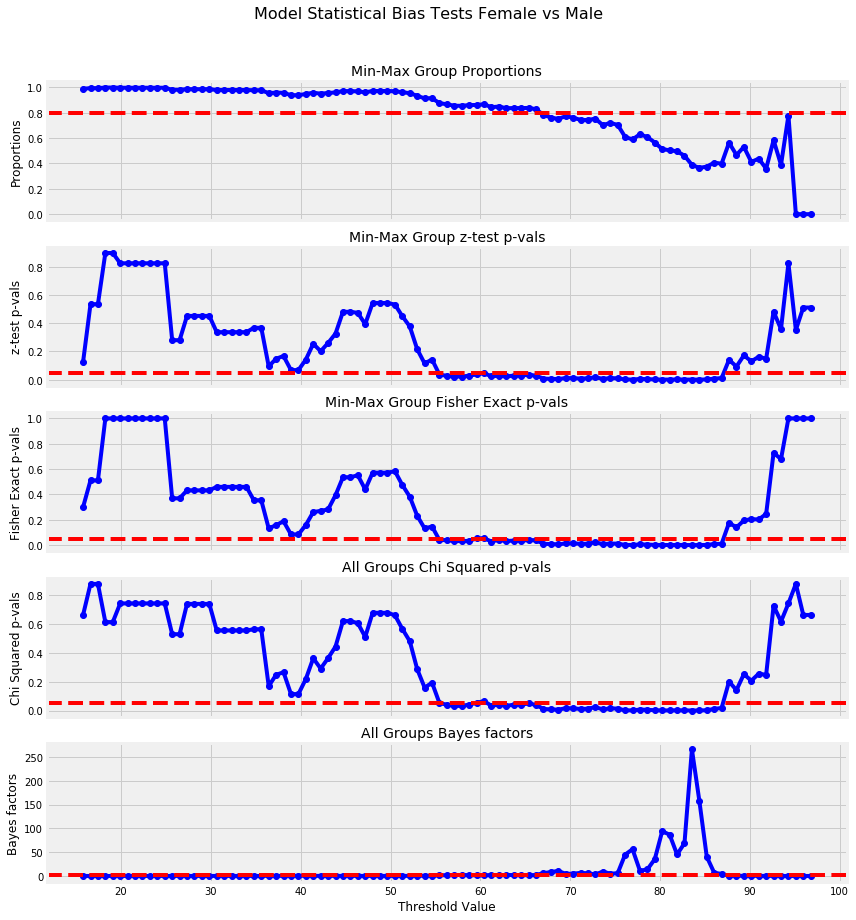

In [25]:
plot_threshold_tests(results=df['credit_score'], labels=df['gender']);

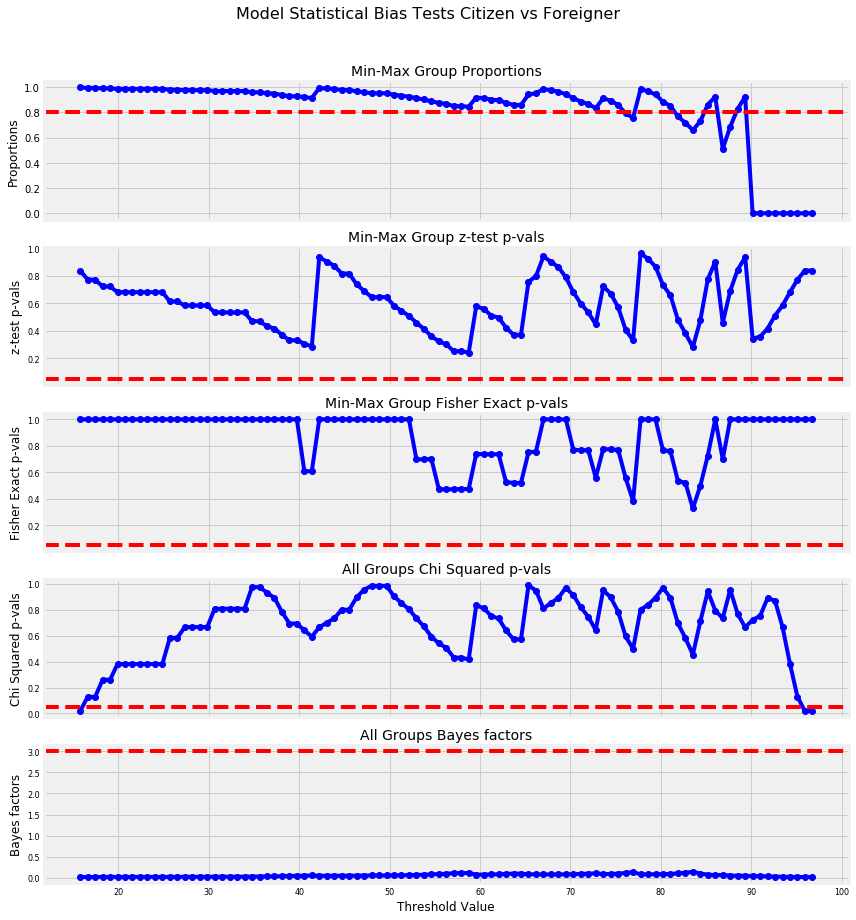

In [26]:
plot_threshold_tests(results=df['credit_score'], labels=df['citizenship_status']);

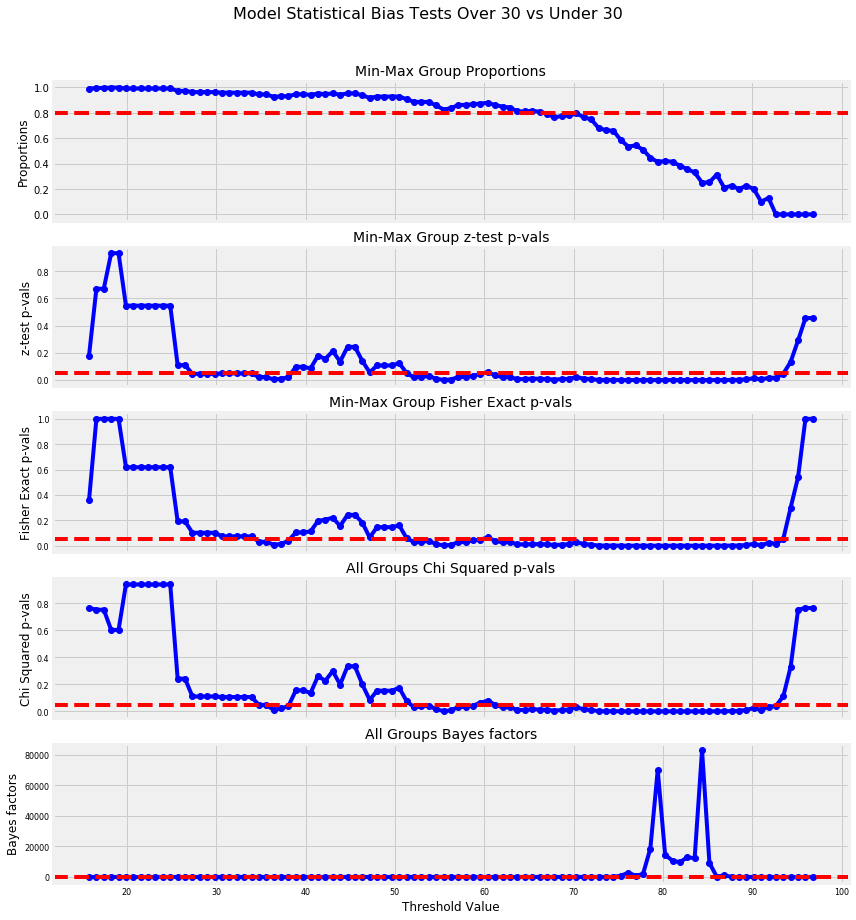

In [27]:
plot_threshold_tests(results=df['credit_score'], labels=df['age_binary']);

## Results and Conclusions

In this notebook we took a publicly available dataset for an important socially sensitive decision making process, and tried to examine the biases in the data, and looked at the effects of building a model off of that data. Hopefully this simple example should illustrate how this package can be used to uncover the bias picked up by machine learning models when trained on biased datasets.